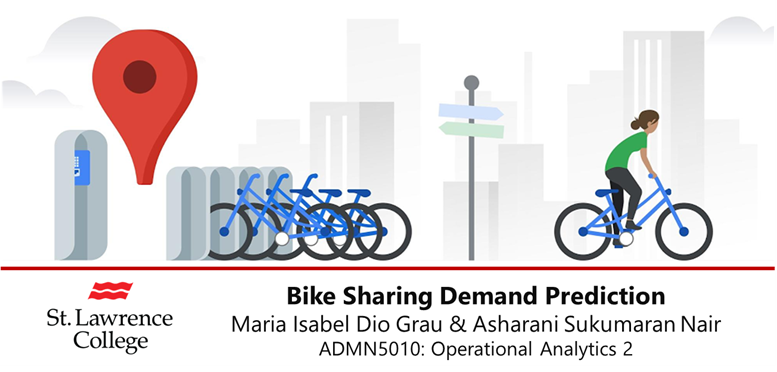

<i>This Python notebook contains a combination of markdown text and code block comments that explain the tasks being executed.</i><br>
***

### Client background and dataset description
Because of the COVID-19 pandemic, bike-sharing company, BoomBikes, suffered a decline in revenue. Recognizing that it may take a while to recover from the economic downturn, the company would like to develop a machine learning model that can predict demand for bikes based on several factors.

The company was able to gather data on their daily bike demand from 2018-2019 - a total of 730 observations. This dataset also includes several factors that could have affected these demand levels, such as temperature, humidity, windspeed, and even time (year, month, weekday, etc.).

The following script can be broken down into the following steps (each line is linked to the code block that executes the corresponding step):
1. <a href='#extract'>Extract dataset from GitHub</a>
2. <a href='#data'>Data exploration and data cleaning</a>
3. <a href='#linear'>Linear regression</a>
4. <a href='#regression'>Demand prediction</a>

Data Source: https://www.kaggle.com/datasets/yasserh/bike-sharing-dataset
***
Before running the program, packages must first be imported in order to access the various functions used by the codes below. If necessary, the packages must first be installed with `pip install [package name]`

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

<a id='extract'></a>
### Extract dataset from GitHub

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/isabelgrau/ADMN5010-Operational-Analytics/main/bikesharing.csv")

In [4]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


<a id='data'></a>
### Data exploration and data cleaning

In [5]:
print("The dataset contains " + str(df.shape[0]) + " observations and " + str(df.shape[1]) + " columns.")

The dataset contains 730 observations and 16 columns.


However, not all columns will be used as features. Some are either correlated with each other or have no predictive power. The following columns will be dropped from the dataset:
- <b>instant</b> - ID; no predictive power; unnecessary since the dataframe already has an index
- <b>dteday</b> - correlated with year and month; this will dropped after visualizing the trend in demand.
- <b>season</b> - correlated with month
- <b>atemp</b> - correlated with temp
- <b>casual and registered</b> - sum of casual and registered is cnt (This would help if the company's products differed between casual and registered bikers. However, the dataset does not specify the difference between the two, so these will be dropped.)

In [6]:
df = df.drop(['instant', 'season', 'atemp', 'casual', 'registered'], axis = 1)
df.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,01-01-2018,0,1,0,6,0,2,14.110847,80.5833,10.749882,985
1,02-01-2018,0,1,0,0,0,2,14.902598,69.6087,16.652113,801
2,03-01-2018,0,1,0,1,1,1,8.050924,43.7273,16.636703,1349
3,04-01-2018,0,1,0,2,1,1,8.200000,59.0435,10.739832,1562
4,05-01-2018,0,1,0,3,1,1,9.305237,43.6957,12.522300,1600


In [7]:
# Check data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 62.9+ KB


In [8]:
# Check for null values

df.isnull().sum()

dteday        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
hum           0
windspeed     0
cnt           0
dtype: int64

There are no null values in the dataset.

In [9]:
# Get statistics of numeric columns

num_columns = ['temp', 'hum', 'windspeed', 'cnt']
df[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
hum,730.0,62.765175,14.237589,0.000000,52.000000,62.625000,72.989575,97.250000
windspeed,730.0,12.763620,5.195841,1.500244,9.041650,12.125325,15.625589,34.000021
cnt,730.0,4508.006849,1936.011647,22.000000,3169.750000,4548.500000,5966.000000,8714.000000


Over the two-year period, demand ranged from as low as 22 bikes to 8,714 bikes, with an average of 4,508. This large variance emphasizes the need for the company to develop an accurate prediction model in order to meet demand.

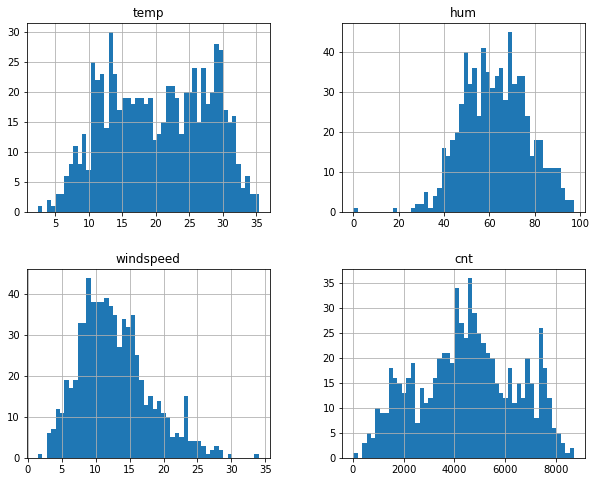

In [10]:
df[num_columns].hist(bins=50, figsize=(10,8))
plt.show()

In [11]:
# Convert dteday to datetime type to visualize trend

df['dteday'] = pd.to_datetime(df['dteday'], format='%d-%m-%Y')

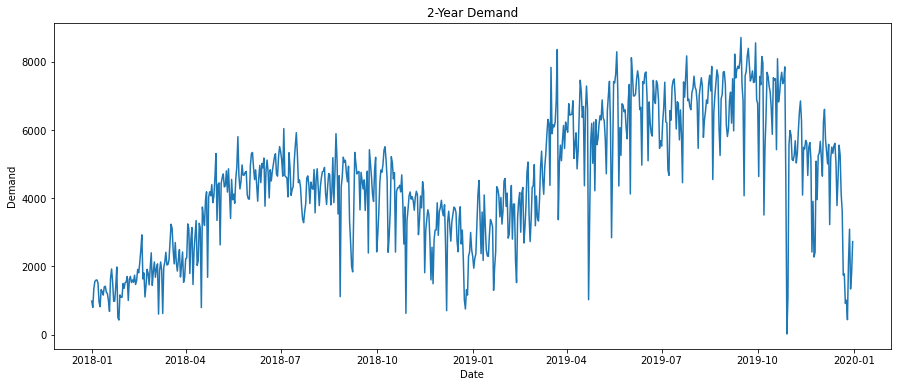

In [12]:
plt.figure(figsize=(15,6))
plt.plot(df['dteday'],df['cnt'])
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('2-Year Demand')
plt.show()

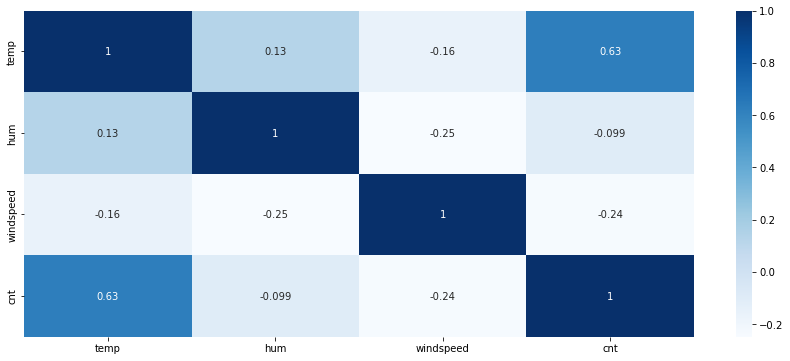

In [13]:
# Create a correlation heatmap

plt.figure(figsize=(15,6))
heatmap = sns.heatmap(df[num_columns].corr(), annot=True, cmap="Blues")

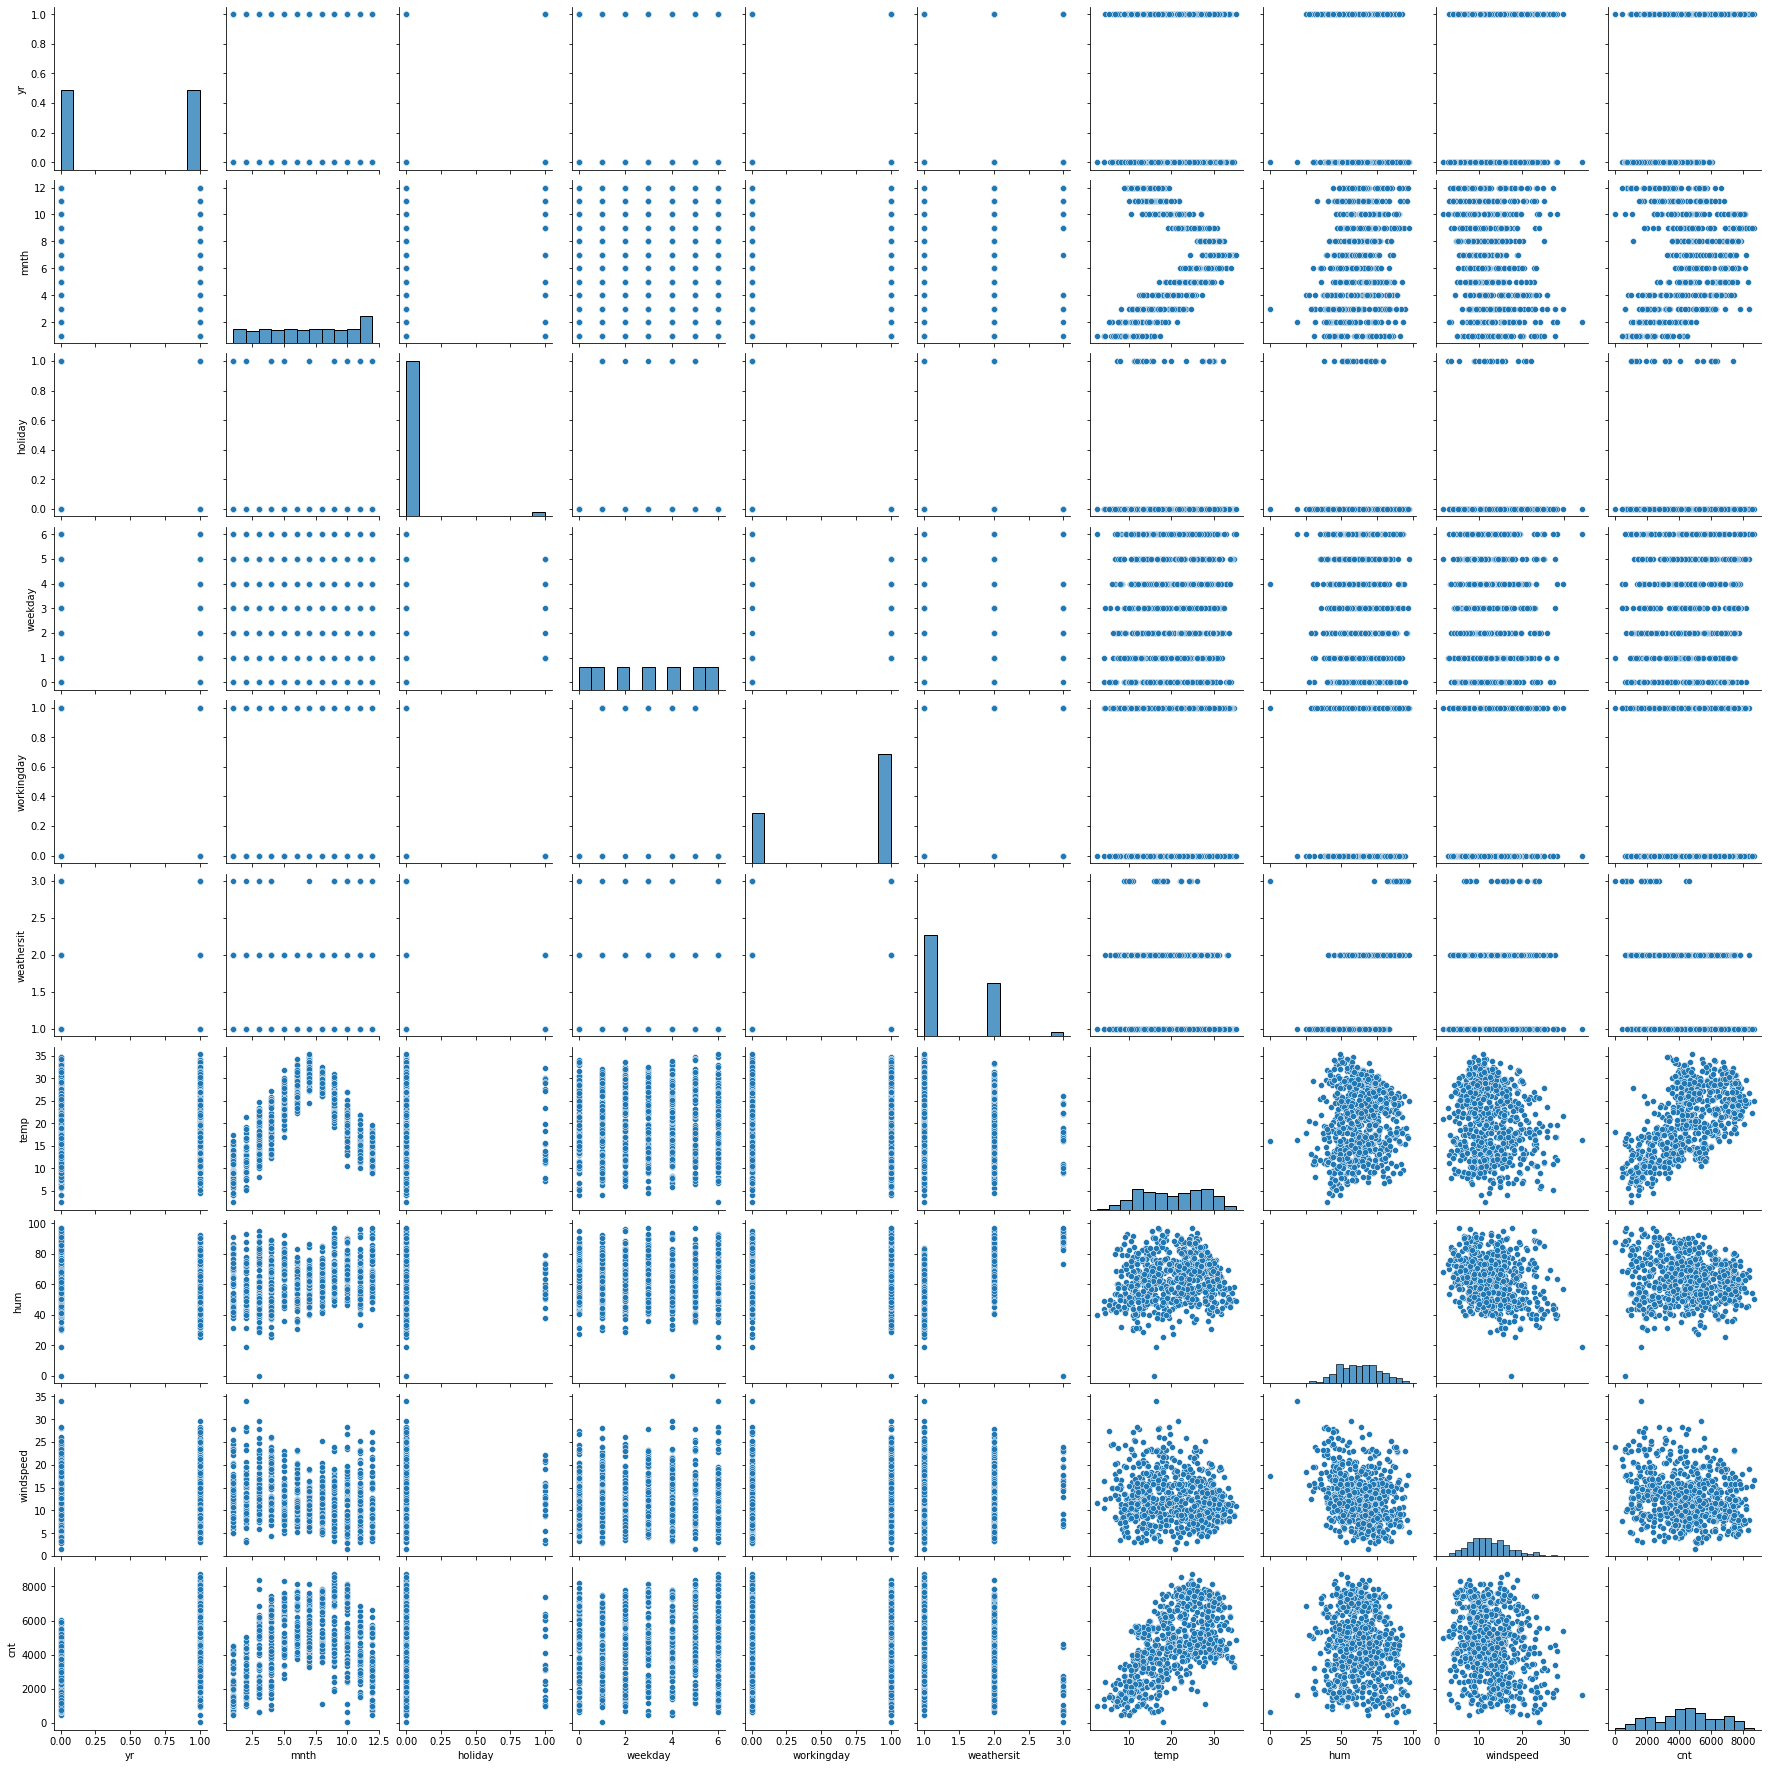

In [14]:
sns.pairplot(df)

The following observations can be made from the correlation matrix, scatterplots, and line chart:
- There is an upward trend in annual demand.
- Demand is positively correlated with temperature. Demand is higher when temperature is warmer.
- There is no strong correlation between demand and either humidity or windspeed. <b>These variables will be dropped.</b>
- Demand is highest in the middle of the year.
- Demand is high when the weather situation is 1 (clear weather) and low when the situation is 3 (heavy rain, fog, thunderstorm).
- There is no relationship between demand and working day. <b>This variable will be dropped.</b>

In [15]:
# drop: date, workingday, hum, windspeed

df = df.drop(['dteday', 'workingday', 'hum', 'windspeed'], axis = 1)
df.head()

,yr,mnth,holiday,weekday,weathersit,temp,cnt
0,0,1,0,6,2,14.110847,985
1,0,1,0,0,2,14.902598,801
2,0,1,0,1,1,8.050924,1349
3,0,1,0,2,1,8.200000,1562
4,0,1,0,3,1,9.305237,1600


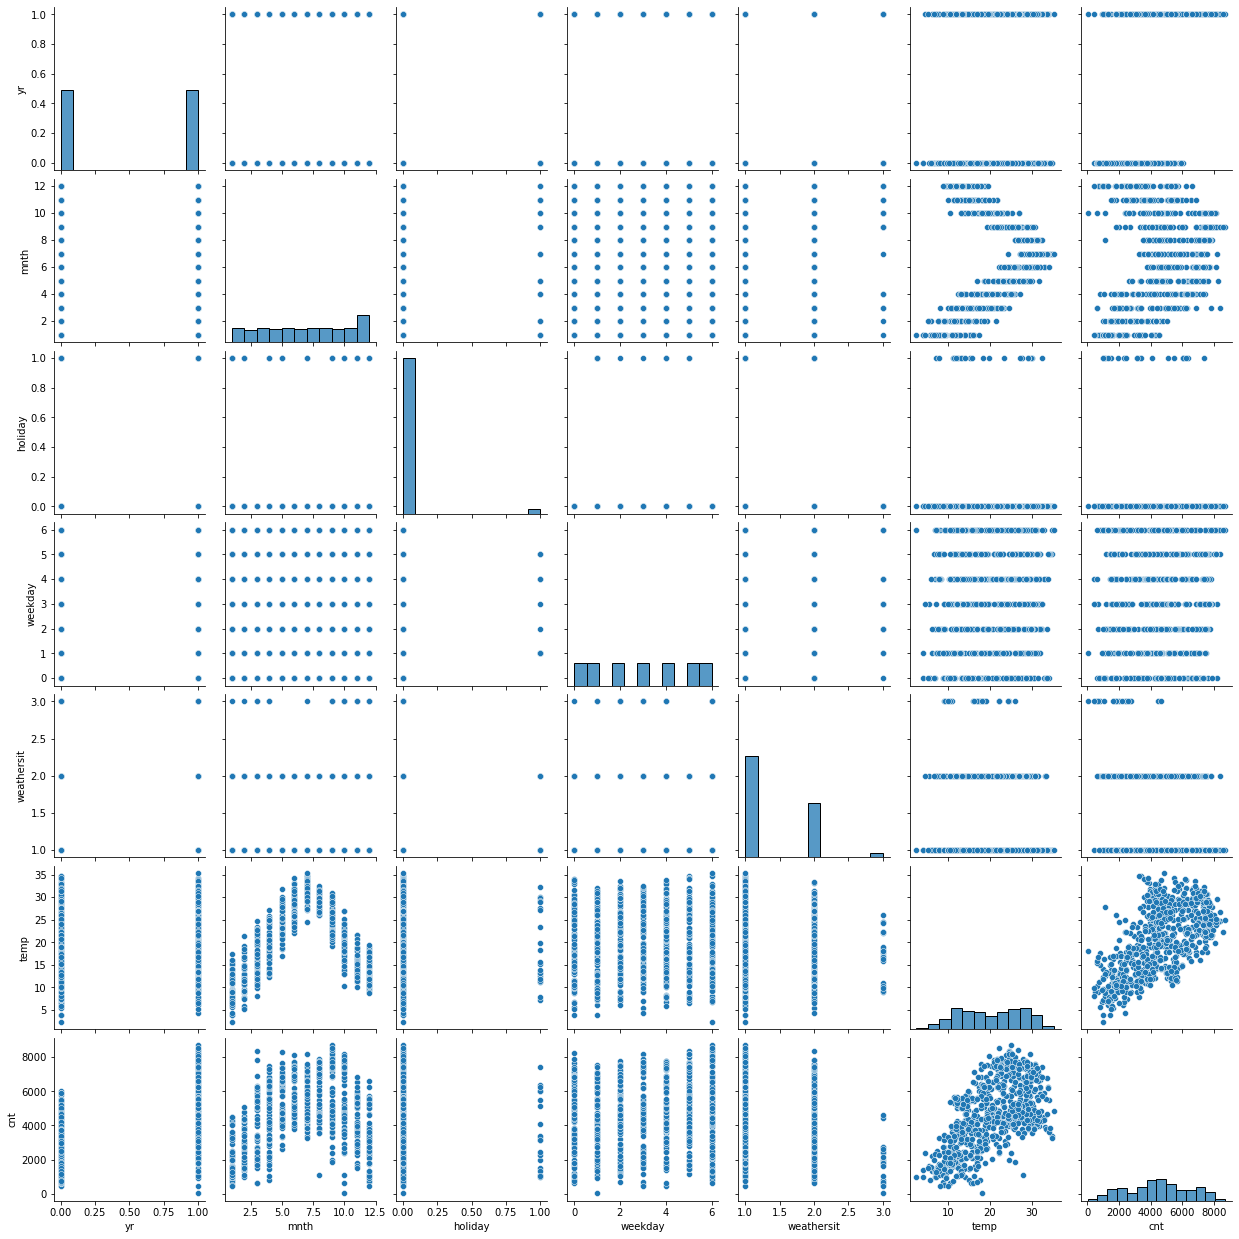

In [16]:
sns.pairplot(df)

<a id='linear'></a>
### Linear regression

Since the dataset is large, using all data will likely show that all independent variables are significant. To resolve this, the dataset will be divided into training and testing datasets.

In [17]:
x = df.drop(['cnt'], axis = 1)
y = df['cnt']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [18]:
x2 = sm.add_constant(x_train)
est = sm.OLS(y_train, x2)

est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     260.0
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          9.24e-151
Time:                        10:40:13   Log-Likelihood:                -4218.3
No. Observations:                 511   AIC:                             8451.
Df Residuals:                     504   BIC:                             8480.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        927.6444    188.029      4.934      0.0

The linear regression shows that all remaining independent variables are significant.

<a id='regression'></a>
### Demand prediction

In [19]:
# Identify the best model

regressors = {
    "LinearRegression": LinearRegression(),
    "XGBRegressor": XGBRegressor(silent=True),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "SVR": SVR(),
    "NuSVR": NuSVR(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
}

In [20]:
df_models = pd.DataFrame(columns=['model', 'run_time','r2 - train', 'r2 - test', 'rmse - train', 'rmse - test'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    scores = cross_val_score(model, 
                             x_train, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse - train': round(np.sqrt(mean_squared_error(y_train, y_pred_train))),
           'rmse - test': round(np.sqrt(mean_squared_error(y_test, y_pred_test))),
           'r2 - train' : round(r2_score(y_train, y_pred_train)*100,2),
           'r2 - test' : round(r2_score(y_test, y_pred_test)*100,2)
    }

    df_models = df_models.append(row, ignore_index=True)

* LinearRegression
* XGBRegressor
[10:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:43:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not

In [21]:
# Order model results

df_models.insert(4, 'r2 difference', df_models['r2 - train'] - df_models['r2 - test'])
df_models['rmse difference'] = df_models['rmse - train'] - df_models['rmse - test']

df_models.head(20).sort_values(by=['r2 - train', 'r2 - test'], ascending=False)

,model,run_time,r2 - train,r2 - test,r2 difference,rmse - train,rmse - test,rmse difference
3,DecisionTreeRegressor,0.0,100.0,74.48,25.52,0,1035,-1035
4,GaussianProcessRegressor,0.0,100.0,23.56,76.44,0,1791,-1791
1,XGBRegressor,0.03,99.89,85.13,14.76,62,790,-728
2,RandomForestRegressor,0.03,97.44,84.36,13.08,301,810,-509
0,LinearRegression,0.0,75.58,76.71,-1.13,931,988,-57
8,Lars,0.0,75.58,76.71,-1.13,931,988,-57
7,Ridge,0.0,75.58,76.62,-1.04,931,990,-59
13,BayesianRidge,0.0,75.58,76.62,-1.04,931,990,-59
12,ARDRegression,0.0,75.57,76.56,-0.99,931,992,-61
10,HuberRegressor,0.0,75.16,76.32,-1.16,939,997,-58


A comparison of $R^{2}$ values, which measure goodness of fit, shows that the Decision Tree Regressor, Gaussian Process Regressor, and XGB Regressor were overfitted models. For all three models, the $R^{2}$ values of the training dataset were higher than those of the testing dataset. This can also be seen in the Root Mean Square Error (RMSE) differences. For all three models, the RMSE, which is a measure of forecast error, increased when evaluated using the testing dataset.

Although the Random Forest Regressor also shows overfitting, with $R^{2}$ values of 97.4% and 84.4% on the training and testing datasets, respectively, it still performs better than the Linear Regression model. As seen in the screenshot below, the $R^{2}$ of the Random Forest Regressor on the testing dataset is higher than both $R^{2}$ values of the Linear Regression model, indicating that it has a better fit. Similarly, the RMSE of the Random Forest Regressor on the testing dataset is lower than both RMSE values of the Linear Regression model, indicating that it is a better model.

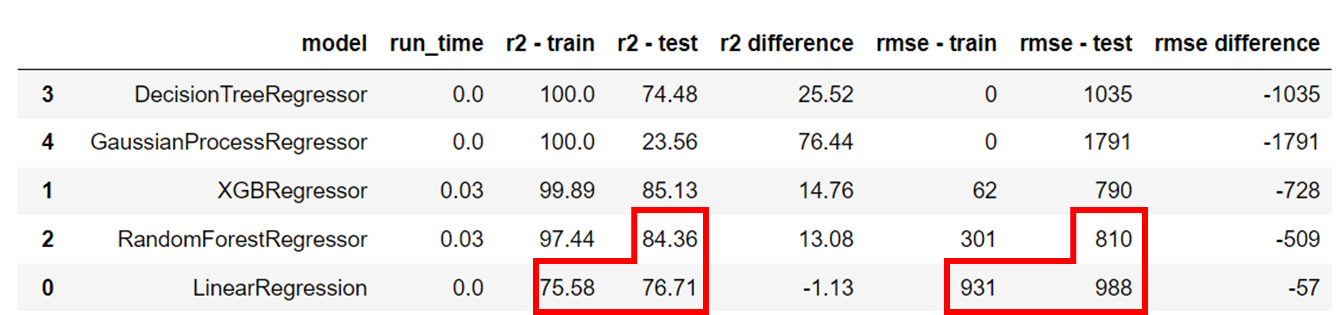

In [22]:
# Assess the best model

regressor = RandomForestRegressor()
model = regressor.fit(x_train, y_train)
y_pred = model.predict(x_test)

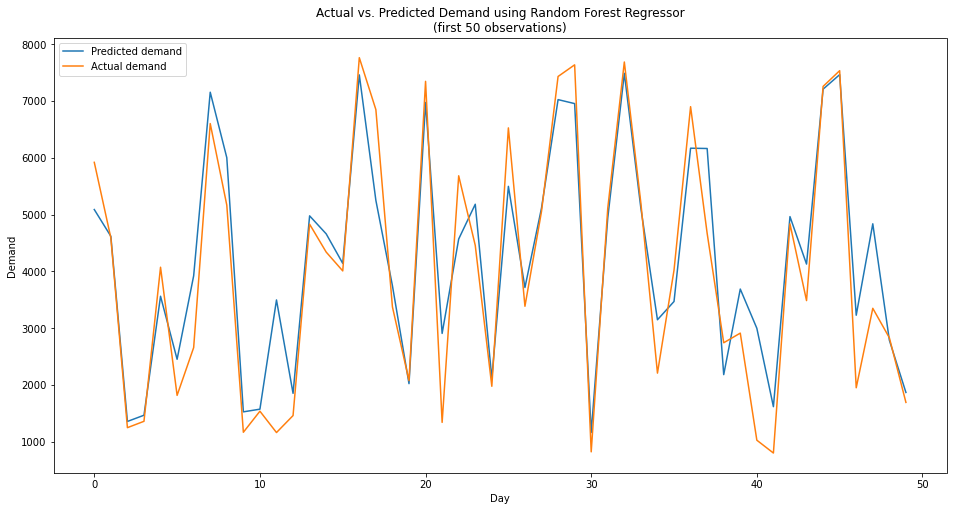

In [23]:
# Plot

test = pd.DataFrame({'Predicted demand':y_pred, 'Actual demand':y_test})
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.title('Actual vs. Predicted Demand using Random Forest Regressor\n(first 50 observations)')
plt.xlabel('Day')
plt.ylabel('Demand')
plt.legend(['Predicted demand','Actual demand'])

The next code identifies the most important features in the Random Forest Regressor model.

In [24]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

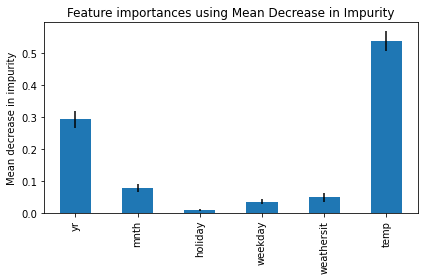

In [25]:
regressor_importances = pd.Series(importances, index=x.columns)

fig, ax = plt.subplots()
regressor_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using Mean Decrease in Impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The figure above shows that temperature, year, and month are the three most important features in the Random Forest Regressor model. However, since year cannot be controlled (i.e., as time passes, the year will keep increasing), the next important feature to consider is the weather situation. Based on the results of the Random Forest Regressor, the following conclusions can be made:
* <b>Temperature</b>: Increase supply of bikes during warmer periods - likely during the Spring and Summer seasons. During cooler periods, demand is low.
* <b>Month</b>: The scatterplot above shows that among the twelve months, demand is highest from June to August. Increase supply during these months.
* <b>Weather Situation</b>: The scatterplot above shows that demand is highest when the weather situation is of category 1 (clear weather) and lowest when the weather situation is of category 3 (heavy rain). Increase supply of bikes during clear weather. During thunderstorms, bikers are likely to stay indoors.

<b>Main conclusion</b>: The model shows that certain features can help predict bike demand. During the summer months, when temperature is warm and weather conditions are clear, the company should increase supply to meet the predicted high demand. Conversely, when the predicted demand is low, the company can decrease supply and use that period of low demand for routine maintenance. This will allow the company to consistently meet demand with high quality bikes.